In [6]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
plt.rcParams.update({
    "figure.dpi": 140,
    "text.usetex": False,
    "font.size": 12,
})

# Heisenberg S=1/2 (T=0) reference for the z-component
m_heis = 0.307
ms2z_heis_T0 = (m_heis**2)/3.0

# Find comparison CSV
CMP_CANDS = [Path("RPA_vs_DQMC_2x2_4x4_6x6.csv"), Path("/mnt/data/RPA_vs_DQMC_2x2_4x4_6x6.csv")]
p_cmp = next((p for p in CMP_CANDS if p.exists()), None)
if p_cmp is None:
    raise FileNotFoundError("RPA_vs_DQMC_2x2_4x4_6x6.csv not found. Put it next to the notebook or in /mnt/data/.")

df = pd.read_csv(p_cmp)

# Standardize minimal expected columns & types
def colex(df):
    d = df.copy()
    d.columns = [c.strip() for c in d.columns]
    for need in ["nx","ny","u","beta"]:
        if need not in d.columns:
            raise KeyError(f"Missing column '{need}' in {p_cmp}")
    for k in ("nx","ny"):
        d[k] = d[k].astype(int, errors="ignore")
    for k in ("u","beta"):
        d[k] = d[k].astype(float, errors="ignore")
    # derived
    if "n" not in d.columns:
        d["n"] = d["nx"]*d["ny"]
    if "j" not in d.columns:
        d["j"] = 4.0/d["u"]
    if "betaj" not in d.columns:
        d["betaj"] = d["beta"]*d["j"]

    # Some pipelines saved DQMC columns without suffix; allow both
    def first_present(cols):
        for c in cols:
            if c in d.columns: return c
        return None

    # Ensure we have ms2_z from DQMC and RPA
    if "ms2_z_dqmc" not in d.columns:
        c = first_present(["ms2_z"])
        if c: d = d.rename(columns={c:"ms2_z_dqmc"})
    if "ms2_z_rpa" not in d.columns:
        # If missing, try reconstruct from Spipi_rpa / N
        if "Spipi_rpa" in d.columns:
            d["ms2_z_rpa"] = d["Spipi_rpa"]/d["n"]

    # Ensure DQMC channels exist (use unsuffixed if needed)
    for bare, suff in [("spipi","spipi_dqmc"), ("spi0","spi0_dqmc"),
                       ("s0pi","s0pi_dqmc"), ("s00","s00_dqmc")]:
        if suff not in d.columns and bare in d.columns:
            d = d.rename(columns={bare:suff})

    return d

df = colex(df)

# Restrict to square L=2,4,6 if desired
keepL = {2,4,6}
df = df[(df["nx"]==df["ny"]) & (df["nx"].isin(keepL))].copy()

print("Loaded rows:", len(df))
display(df.head())


Loaded rows: 27


,nx,ny,u,beta,n,j,betaj,d,spipi_dqmc,spi0_dqmc,...,s00_dqmc,ms2_z_dqmc,m2_su2_dqmc,Spipi_rpa,Spi0_rpa,S0pi_rpa,S00_rpa,ms2_z_rpa,m2_su2_rpa,alpha_norm
0,2,2,1.0,1.0,4,4.0,4.0,0.211887,0.144056,0.144056,...,0.144056,0.036014,0.108042,0.199750,0.120369,0.120369,0.135739,0.049938,0.149813,0.878513
1,4,4,1.0,1.0,16,4.0,4.0,0.218949,0.166466,0.141928,...,0.111780,0.010404,0.031212,0.178089,0.138776,0.138776,0.121136,0.011131,0.033392,0.694844
2,6,6,1.0,1.0,36,4.0,4.0,0.219136,0.184875,0.138527,...,0.099019,0.005135,0.015406,0.178569,0.133874,0.133874,0.121051,0.004960,0.014881,0.699697
3,2,2,1.0,4.0,4,4.0,16.0,0.189895,0.155053,0.155053,...,0.155053,0.038763,0.116289,0.310105,0.034456,0.034456,0.241193,0.077526,0.232579,0.241193
4,4,4,1.0,4.0,16,4.0,16.0,0.211961,0.192132,0.141509,...,0.100928,0.012008,0.036025,0.354172,0.174560,0.174560,0.200263,0.022136,0.066407,0.332818


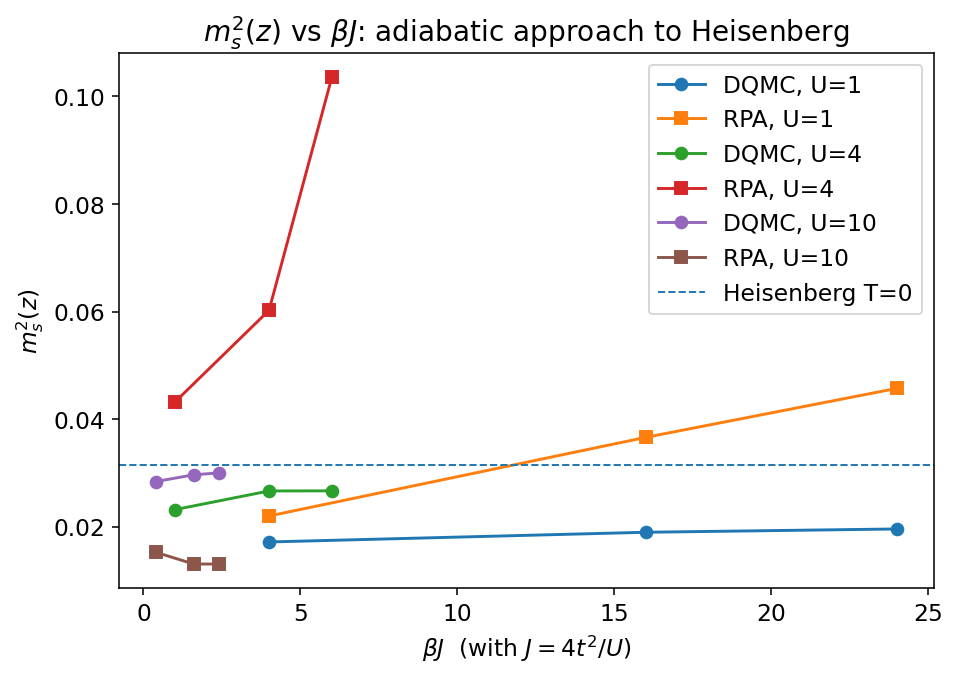

In [7]:
def fig_ms2_vs_betaJ(df, savepath=None):
    plt.figure(figsize=(7,5))
    for U in sorted(df["u"].unique()):
        sub = df[df["u"]==U]
        g = sub.groupby("betaj").agg(ms2_dqmc=("ms2_z_dqmc","mean"),
                                     ms2_rpa =("ms2_z_rpa","mean")).reset_index()
        plt.plot(g["betaj"], g["ms2_dqmc"], marker="o", label=f"DQMC, U={U:g}")
        if "ms2_rpa" in g:  # guard if missing
            plt.plot(g["betaj"], g["ms2_rpa"],  marker="s", label=f"RPA, U={U:g}")
    plt.axhline(ms2z_heis_T0, ls="--", lw=1.0, label="Heisenberg T=0")
    plt.xlabel(r"$\beta J$  (with $J=4t^2/U$)")
    plt.ylabel(r"$m_s^2(z)$")
    plt.title(r"$m_s^2(z)$ vs $\beta J$: adiabatic approach to Heisenberg")
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

fig_ms2_vs_betaJ(df, savepath="fig_ms2_vs_betaJ.png")


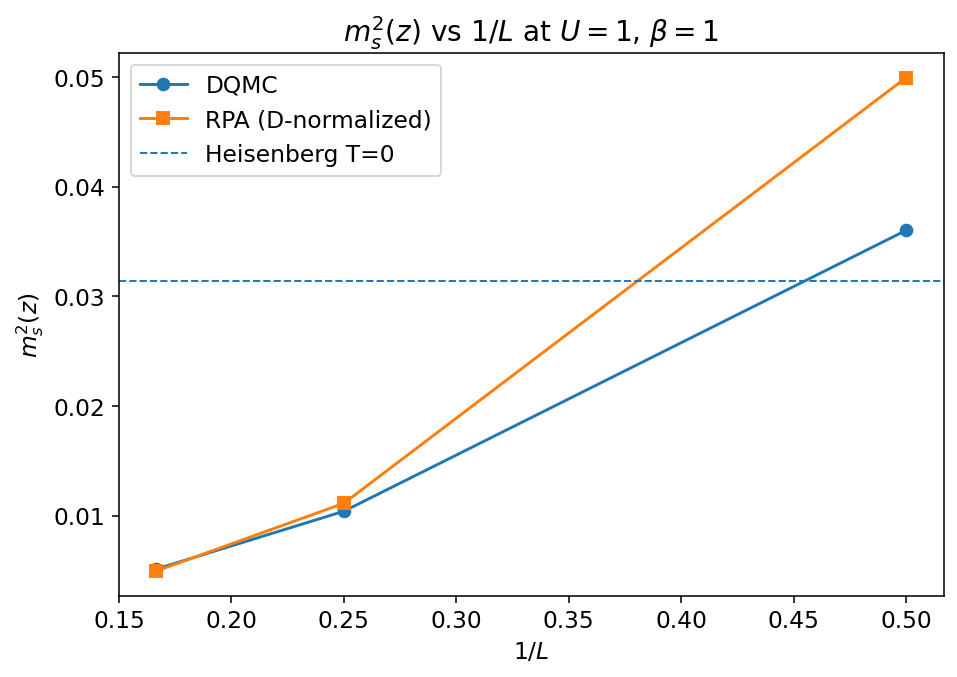

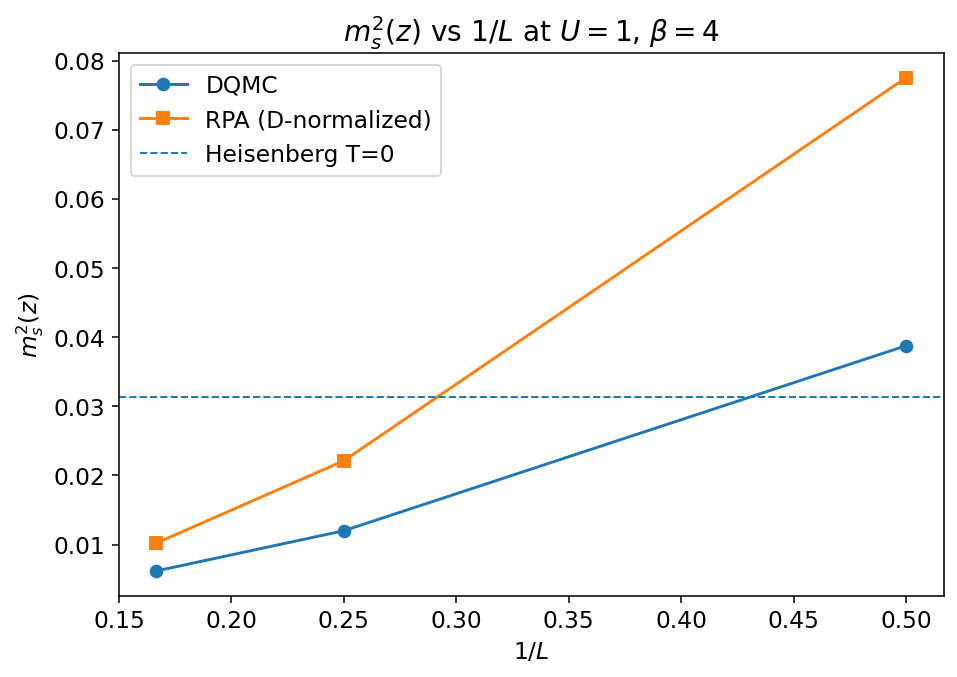

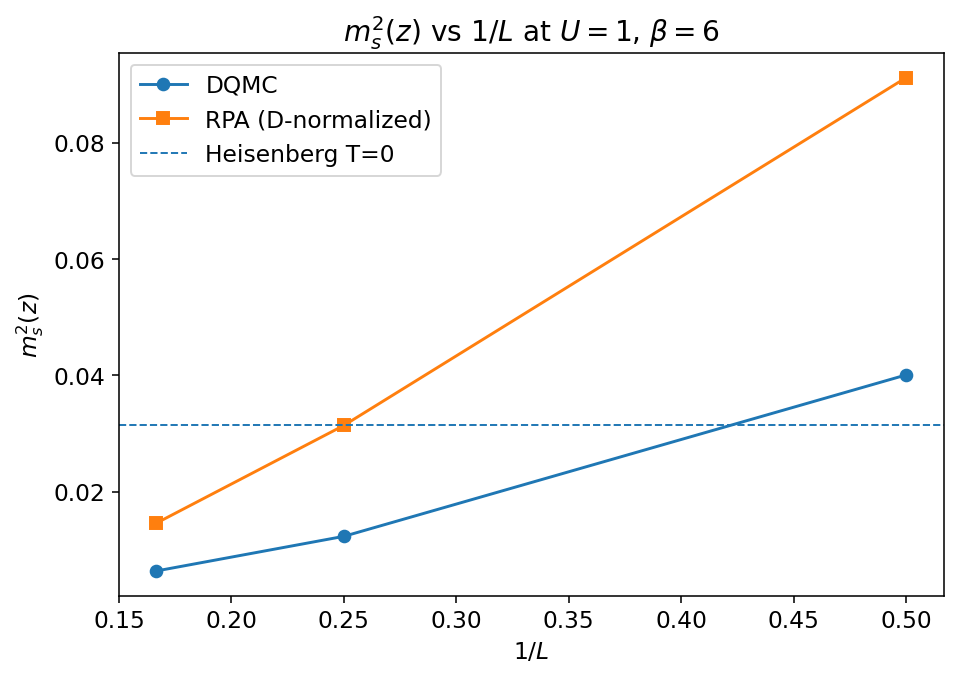

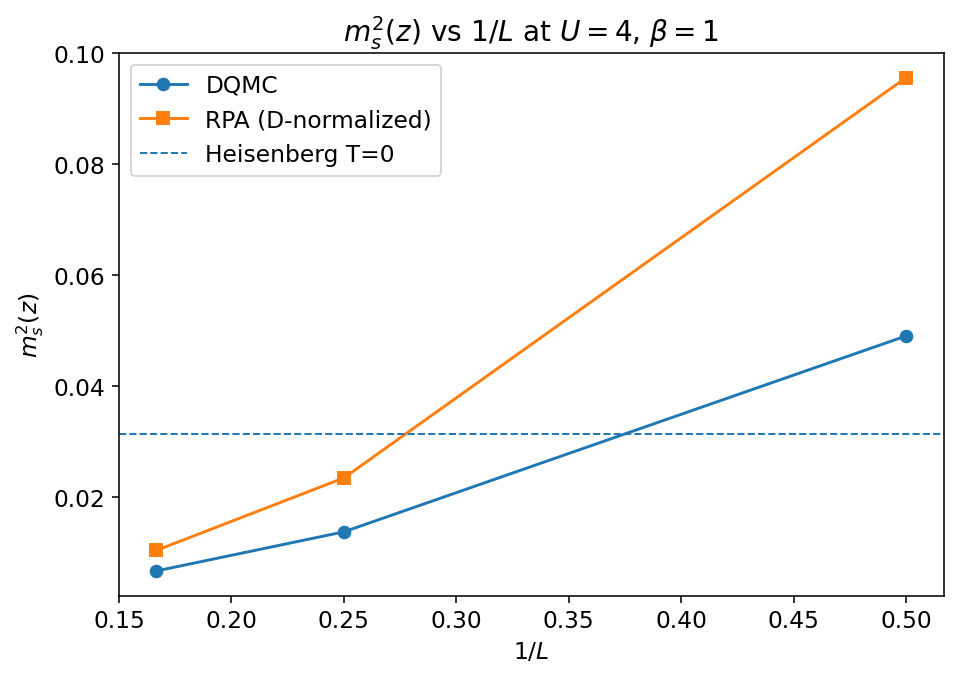

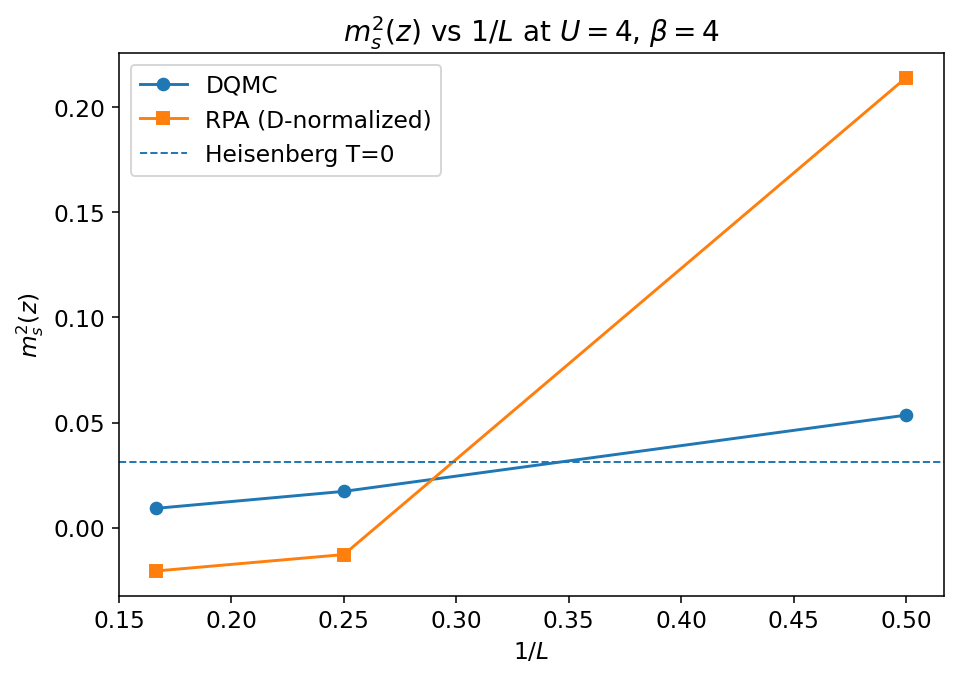

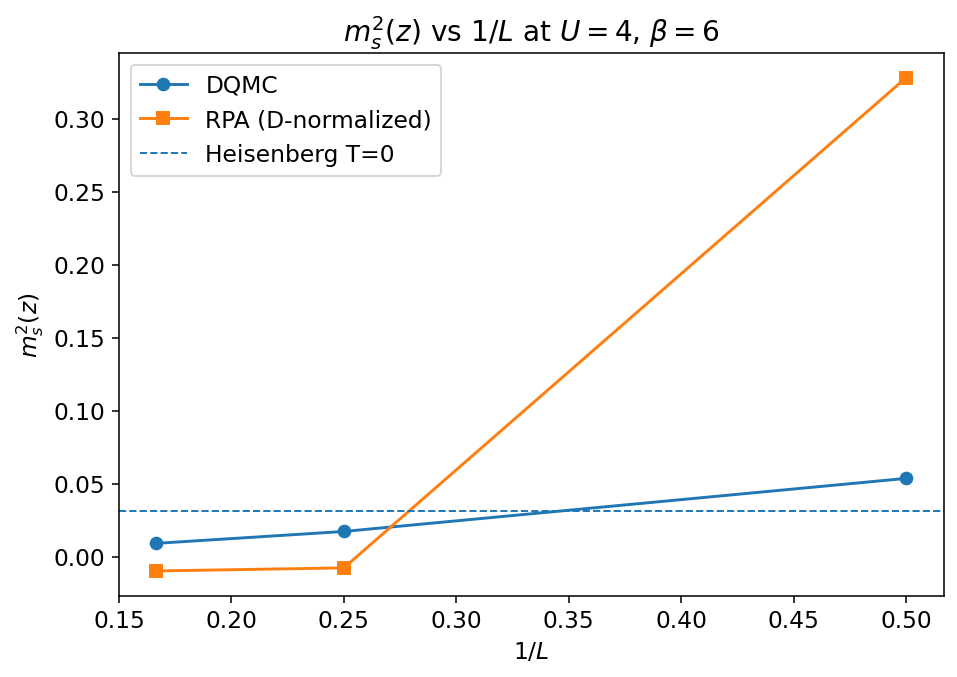

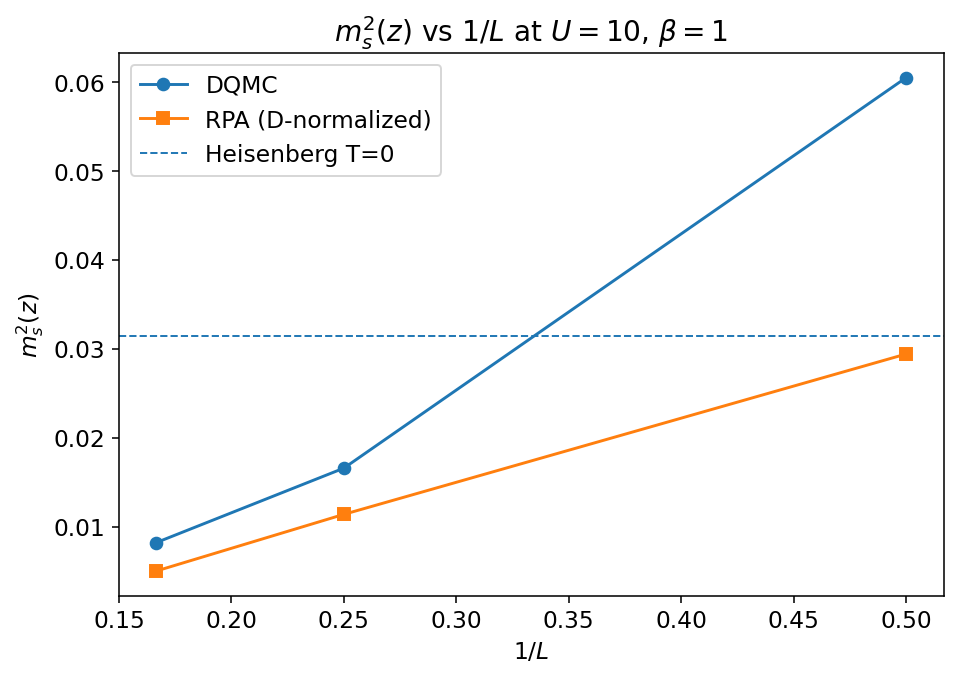

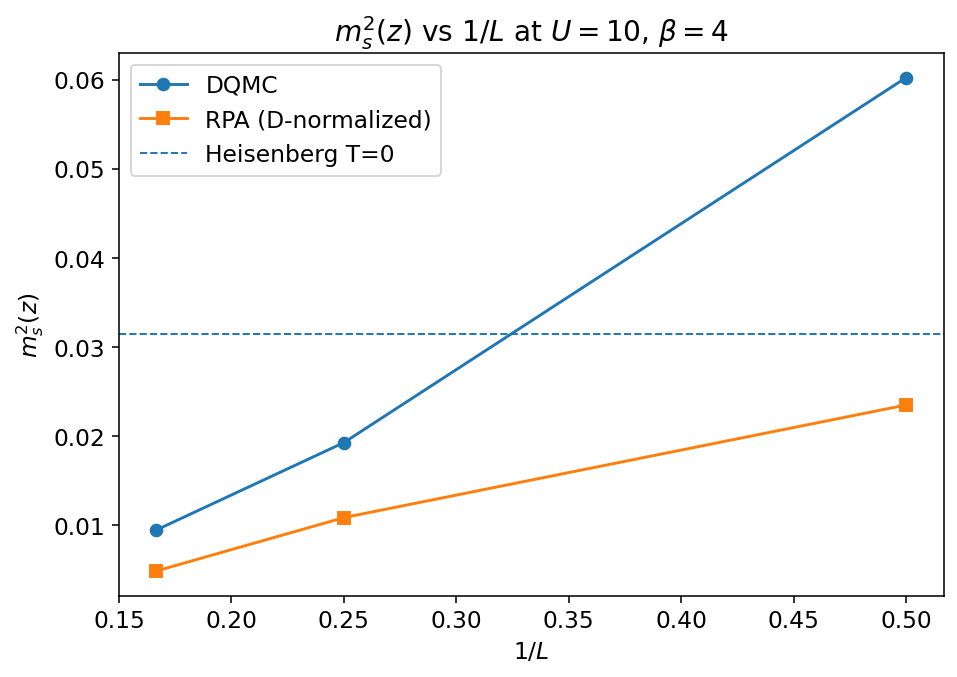

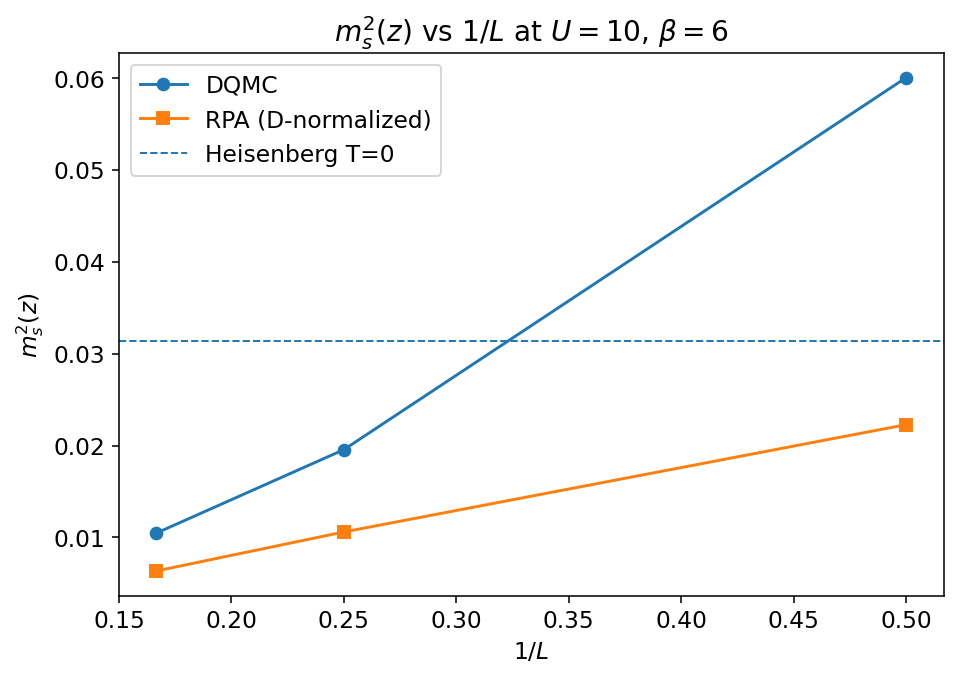

In [8]:
def fig_ms2_vs_invL(df, fixed_beta, fixed_U, savepath=None):
    sub = df[(np.isclose(df["beta"], fixed_beta)) & (np.isclose(df["u"], fixed_U))].copy()
    if sub.empty:
        print(f"No data for beta={fixed_beta}, U={fixed_U}")
        return
    sub = sub.sort_values("nx")
    x = 1.0/sub["nx"].astype(float).values
    y_dqmc = sub["ms2_z_dqmc"].values
    y_rpa  = sub["ms2_z_rpa"].values if "ms2_z_rpa" in sub.columns else None

    plt.figure(figsize=(7,5))
    plt.plot(x, y_dqmc, marker="o", label="DQMC")
    if y_rpa is not None and np.isfinite(y_rpa).any():
        plt.plot(x, y_rpa, marker="s", label="RPA (D-normalized)")
    plt.axhline(ms2z_heis_T0, ls="--", lw=1.0, label="Heisenberg T=0")
    plt.xlabel(r"$1/L$")
    plt.ylabel(r"$m_s^2(z)$")
    plt.title(fr"$m_s^2(z)$ vs $1/L$ at $U={fixed_U:g}$, $\beta={fixed_beta:g}$")
    plt.legend(); plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Example calls (adjust to the sets you have)
for U in sorted(df["u"].unique()):
    for beta in sorted(df["beta"].unique()):
        fig_ms2_vs_invL(df, fixed_beta=beta, fixed_U=U)


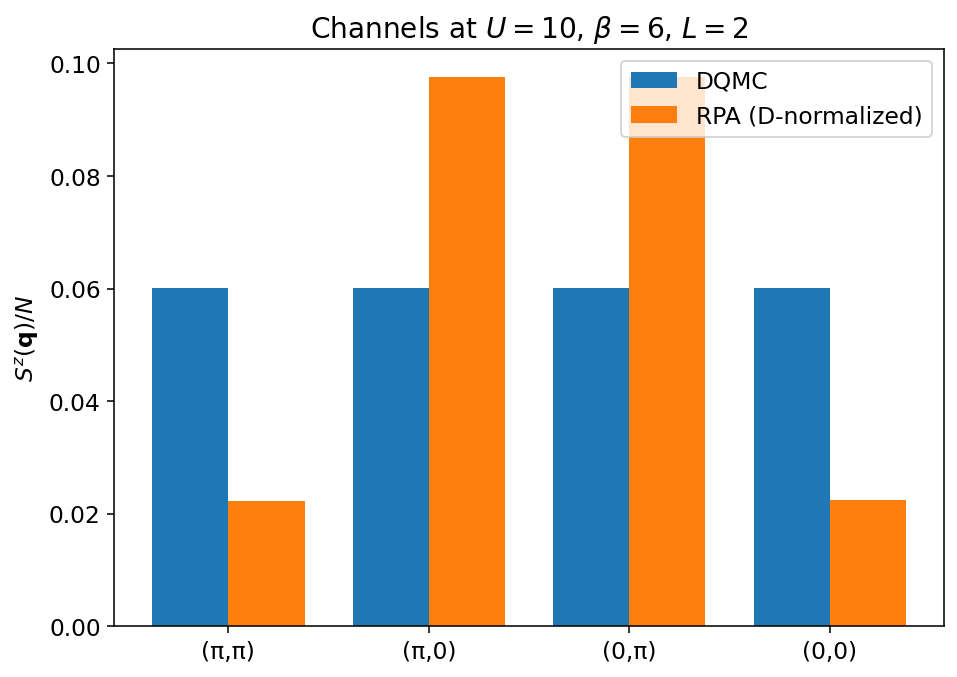

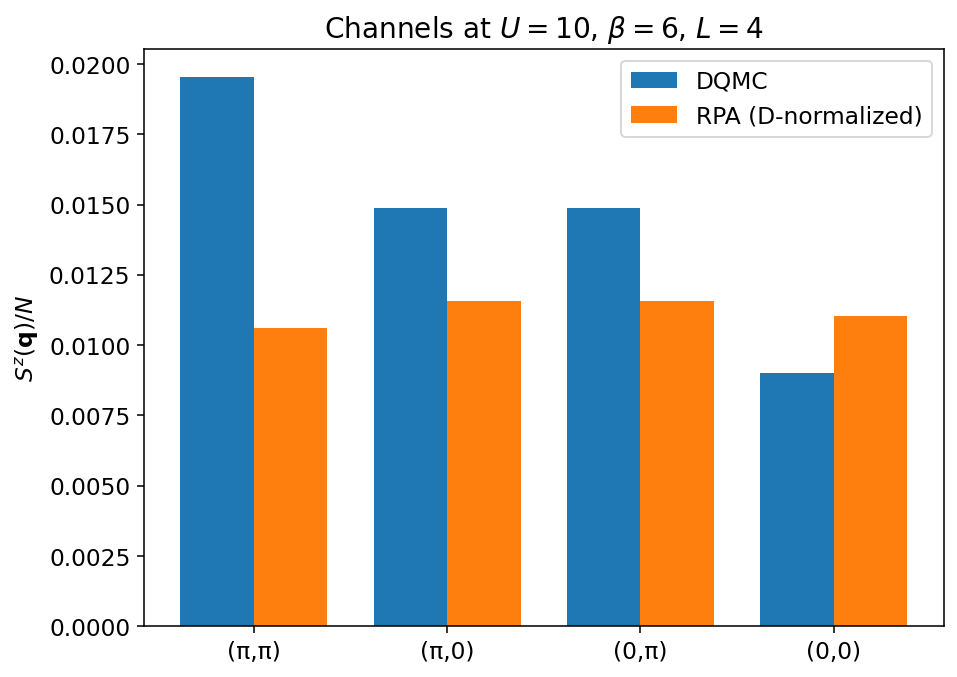

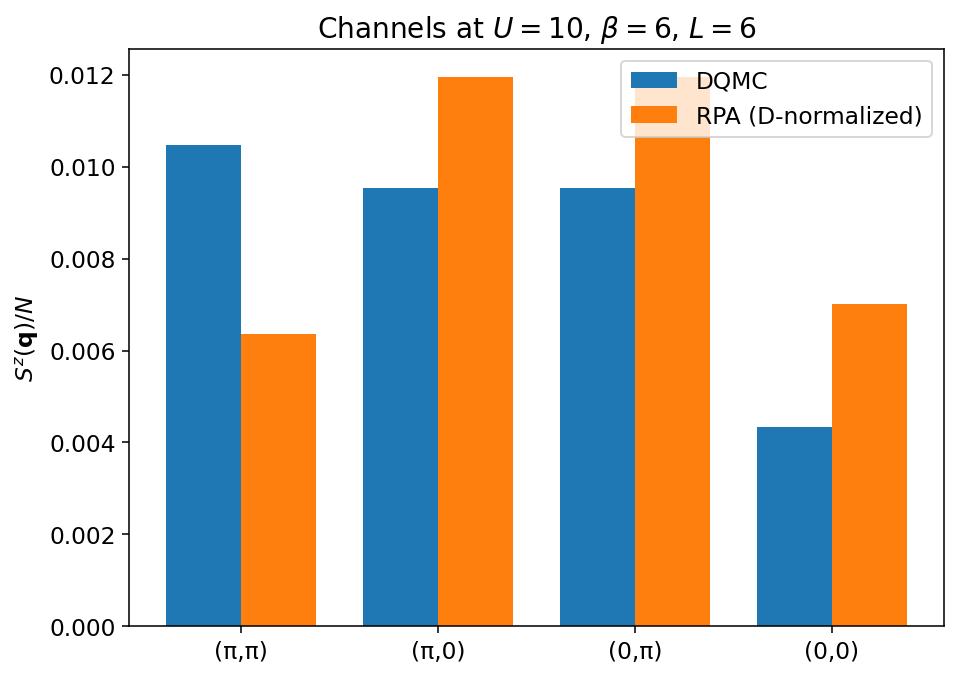

In [9]:
def fig_channels_bar(df, fixed_beta, fixed_U, fixed_L, savepath=None):
    sub = df[(np.isclose(df["beta"], fixed_beta)) & (np.isclose(df["u"], fixed_U)) & (df["nx"]==fixed_L)]
    if sub.empty:
        print(f"No data for beta={fixed_beta}, U={fixed_U}, L={fixed_L}")
        return
    row = sub.iloc[0]
    N = int(row["n"])
    labs = ["(π,π)","(π,0)","(0,π)","(0,0)"]
    dqmc = [row.get("spipi_dqmc", np.nan), row.get("spi0_dqmc", np.nan),
            row.get("s0pi_dqmc", np.nan),  row.get("s00_dqmc", np.nan)]
    rpa  = [row.get("Spipi_rpa", np.nan),  row.get("Spi0_rpa", np.nan),
            row.get("S0pi_rpa", np.nan),   row.get("S00_rpa", np.nan)]
    dqmc = [v/N if np.isfinite(v) else np.nan for v in dqmc]
    rpa  = [v/N if np.isfinite(v) else np.nan for v in rpa]

    x = np.arange(len(labs)); w = 0.38
    plt.figure(figsize=(7,5))
    if np.isfinite(dqmc).any(): plt.bar(x - w/2, dqmc, width=w, label="DQMC")
    if np.isfinite(rpa).any():  plt.bar(x + w/2, rpa,  width=w, label="RPA (D-normalized)")
    plt.ylabel(r"$S^z(\mathbf{q})/N$")
    plt.title(fr"Channels at $U={fixed_U:g}$, $\beta={fixed_beta:g}$, $L={fixed_L}$")
    plt.xticks(x, labs); plt.legend(); plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Example: largest beta, largest U available
if len(df)>0:
    beta_max = df["beta"].max()
    U_max = df["u"].max()
    for L in sorted(df["nx"].unique()):
        fig_channels_bar(df, fixed_beta=beta_max, fixed_U=U_max, fixed_L=L)


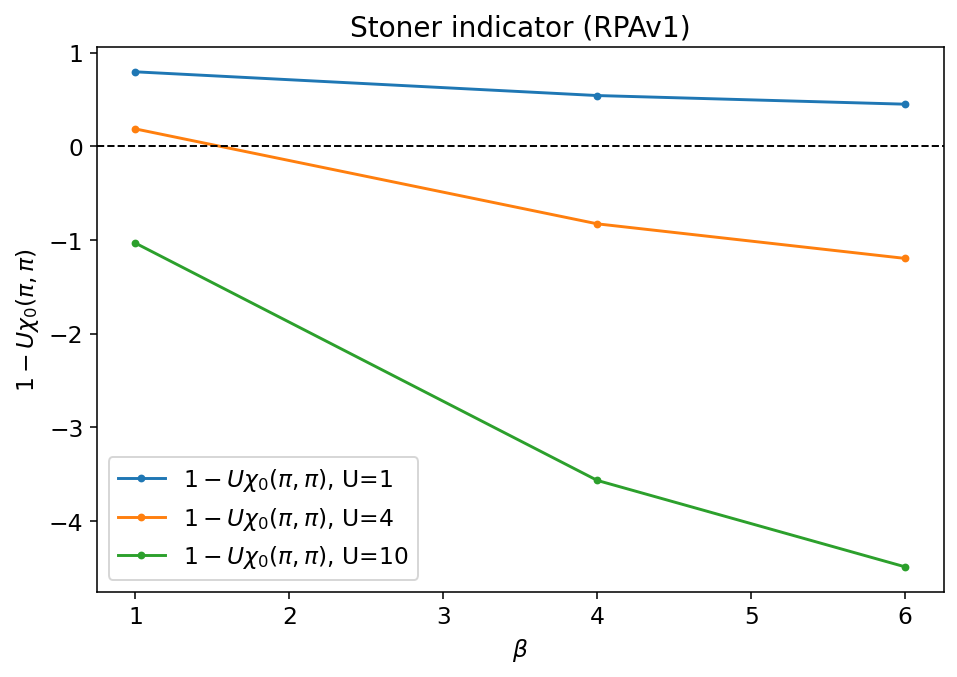

In [10]:
def grid_k(Nx, Ny):
    mx = np.arange(Nx); my = np.arange(Ny)
    kx = 2*np.pi*mx/Nx; ky = 2*np.pi*my/Ny
    return np.meshgrid(kx, ky, indexing='xy')

def dispersion(kx, ky, t=1.0, mu=0.0):
    return -2*t*(np.cos(kx)+np.cos(ky)) - mu

def fermi(x, beta):
    xbeta = np.clip(beta*x, -700, 700)
    return 1.0/(1.0 + np.exp(xbeta))

def chi0_pi_pi(beta, Nx=128, Ny=128, t=1.0, mu=0.0):
    # Compute uniform χ0 at q=(π,π) for a dense grid
    kx, ky = grid_k(Nx, Ny)
    eps = dispersion(kx, ky, t=t, mu=mu)
    f = fermi(eps, beta)
    qx, qy = np.pi, np.pi
    eps_q = dispersion((kx+qx)%(2*np.pi), (ky+qy)%(2*np.pi), t=t, mu=mu)
    de = eps_q - eps
    term = np.zeros_like(de)
    mask = np.isclose(de, 0.0, atol=1e-12)
    term[~mask] = (f - fermi(eps_q, beta))[~mask] / de[~mask]
    term[mask]  = beta * f[mask]*(1.0 - f[mask])
    return float(np.mean(term))

def fig_stoner(beta_list, U_list, savepath=None):
    vals = {}
    for U in U_list:
        y = []
        for beta in beta_list:
            chi0 = chi0_pi_pi(beta)
            y.append(1.0 - U*chi0)
        vals[U] = np.array(y)

    plt.figure(figsize=(7,5))
    for U in U_list:
        plt.plot(beta_list, vals[U], marker=".", label=f"$1-U\\chi_0(\\pi,\\pi)$, U={U:g}")
    plt.axhline(0.0, color="k", lw=1.0, ls="--")
    plt.xlabel(r"$\beta$")
    plt.ylabel(r"$1-U\chi_0(\pi,\pi)$")
    plt.title("Stoner indicator (RPAv1)")
    plt.legend(); plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Example: show Stoner indicator for U = 1, 4, 10 across your beta range
beta_sorted = sorted(df["beta"].unique())
fig_stoner(beta_sorted, U_list=sorted(df["u"].unique()), savepath="fig_stoner.png")
